In [63]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
EPOCHS = 200
BATCH_SIZE = 512

In [31]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [33]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [34]:
df = df.drop("Time", axis=1)

In [35]:
X, y = df.drop("Class", axis=1), df["Class"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["Class"])

In [37]:
ss = StandardScaler()
ss = ss.fit(X_train)

In [38]:
X_train[X_train.columns] = ss.transform(X_train)
X_test[X_test.columns] = ss.transform(X_test)

In [39]:
def build_autoencoder(input_dim, encoding_dim):
    input_data = layers.Input(shape=(input_dim,))

    x = layers.Dense(input_dim, activation="relu")(input_data)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    
    x = layers.Dense(32, activation="relu")(x)
    
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(input_dim, activation="relu")(x)

    autoencoder = tf.keras.Model(input_data, x)

    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss="mse"
    )

    return autoencoder

In [40]:
autoencoder = build_autoencoder(X_train.shape[1], 64)
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_36 (Dense)            (None, 29)                870       
                                                                 
 dense_37 (Dense)            (None, 128)               3840      
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dense_40 (Dense)            (None, 64)                2112      
                                                                 
 dense_41 (Dense)            (None, 128)               8320

In [42]:
autoencoder.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, 
            restore_best_weights=True
        )
    ],
    batch_size=BATCH_SIZE
)

Epoch 1/200
446/446 [==============================] - 4s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 2/200
446/446 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/200
446/446 [==============================] - 2s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/200
446/446 [==============================] - 2s 4ms/step - loss: 9.9657e-04 - val_loss: 9.9090e-04
Epoch 5/200
446/446 [==============================] - 2s 4ms/step - loss: 9.7553e-04 - val_loss: 9.9677e-04
Epoch 6/200
446/446 [==============================] - 2s 4ms/step - loss: 9.7410e-04 - val_loss: 0.0010
Epoch 7/200
446/446 [==============================] - 2s 5ms/step - loss: 9.6296e-04 - val_loss: 9.7025e-04
Epoch 8/200
446/446 [==============================] - 2s 4ms/step - loss: 9.5274e-04 - val_loss: 9.6363e-04
Epoch 9/200
446/446 [==============================] - 2s 4ms/step - loss: 9.4005e-04 - val_loss: 9.6596e-04
Epoch 10/200
446/446 [=========================

In [51]:
encoder = tf.keras.Model(autoencoder.layers[0].input, autoencoder.layers[-4].output)

In [53]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

1781/1781 [==============================] - 3s 1ms/step


In [55]:
X_train_encoded.shape

(227845, 32)

In [58]:
clf = LogisticRegression(n_jobs=-1)
clf = clf.fit(X_train_encoded, y_train)

In [59]:
y_pred = clf.predict(X_test_encoded)

In [61]:
cm = confusion_matrix(y_test, y_pred)

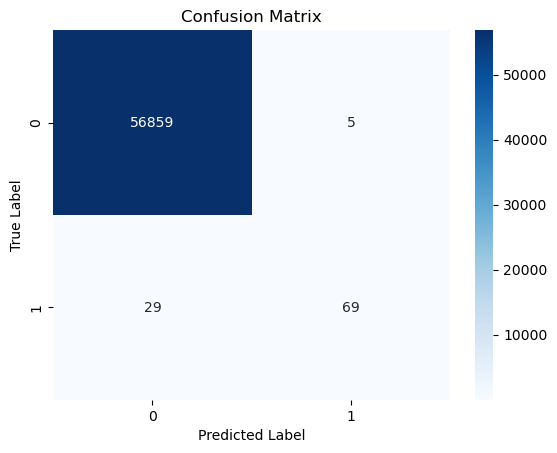

In [62]:
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [64]:
f1_score(y_test, y_pred)

0.8023255813953488

In [65]:
# Now lets try it without the autoencoder

In [66]:
clf = LogisticRegression(n_jobs=-1)
clf = clf.fit(X_train, y_train)

In [67]:
y_pred = clf.predict(X_test)

In [68]:
cm = confusion_matrix(y_test, y_pred)

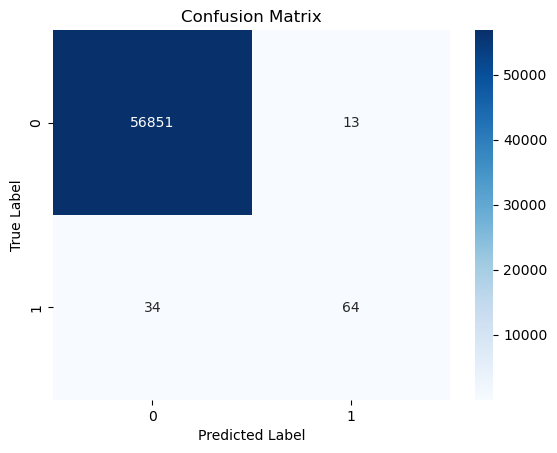

In [69]:
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [70]:
f1_score(y_test, y_pred)

0.7314285714285713